In [1]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
import os
import numpy as np
import copy

In [2]:
from OpSimSummary import summarize_opsim as oss
import sncosmo

/usr/local/manual/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
#import seaborn as sns
#sns.set()

In [4]:
from metrics import PerSNMetric
from efficiencyTable import EfficiencyTable

In [5]:
from lsst.sims.photUtils import BandpassDict

In [6]:
from lsst.sims.utils.coordinateTransformations import haversine

In [50]:
# Catsim bandpasses
lsst_bp = BandpassDict.loadTotalBandpassesFromFiles()

In [75]:
# sncosmo Bandpasses required for fitting
throughputsdir = os.getenv('THROUGHPUTS_DIR')

from astropy.units import Unit
bandPassList = ['u', 'g', 'r', 'i', 'z', 'y']
banddir = os.path.join(os.getenv('THROUGHPUTS_DIR'), 'baseline')

for band in bandPassList:

    # setup sncosmo bandpasses
    bandfname = banddir + "/total_" + band + '.dat'


    # register the LSST bands to the SNCosmo registry
    # Not needed for LSST, but useful to compare independent codes
    # Usually the next two lines can be merged,
    # but there is an astropy bug currently which affects only OSX.
    numpyband = np.loadtxt(bandfname)
    print band
    sncosmoband = sncosmo.Bandpass(wave=numpyband[:, 0],
                                   trans=numpyband[:, 1],
                                   wave_unit=Unit('nm'),
                                   name=band)
    sncosmo.registry.register(sncosmoband, force=True)

u
g
r
i
z
y


In [7]:
def distance(ra1, dec1, ra2, dec2):
    """
    Obtain the angular distance in radians between two points with given
    ra, dec values in radians
    
    Parameters
    ----------
    ra1 : array like, mandatory
    dec1 :
    ra2 :
    dec2 :
    """
    cosDelta = np.cos(dec1)* np.cos(dec2) *np.cos(ra1 -ra2) + np.sin(dec1)*np.sin(dec2)
    return np.arccos(cosDelta)

In [8]:
opsimHDF = os.path.join(os.getenv('HOME'), 'data', 'LSST', 'OpSimData', 'storage.h5')
summarydf = pd.read_hdf(opsimHDF, 'table')
# df = df.query('propID == [364, 366]')

In [9]:
summarydf.query('fieldID == 290')[['fieldRA', 'fieldDec']].head()

,fieldRA,fieldDec
95688,6.097944,-1.10516
95703,6.097944,-1.10516
95704,6.097944,-1.10516
96854,6.097944,-1.10516
96863,6.097944,-1.10516


###  List of Positions to Try out

In [10]:
posns = pd.read_csv('example_data/posns.txt', delim_whitespace=True)

In [11]:
posns['ra_radians']= np.radians(posns.RAdeg)
posns['dec_radians']= np.radians(posns.Decdeg)

In [12]:
posns.head()

,position,RAdeg,Decdeg,datapts,ra_radians,dec_radians
0,deep1,349.386,-63.3210,2363,6.097936,-1.105160
1,lsstpos3,190.000,-83.0000,23942,3.316126,-1.448623
2,lsstpos4,20.000,-83.0000,25244,0.349066,-1.448623
3,lsstpos2,120.012,-71.8795,22033,2.094605,-1.254534
4,lsstpos1,240.012,-61.8795,101,4.189000,-1.080001


### Obtaining the Light Curves

In [13]:
posns.ix[0, 'ra_radians']

6.0979360603729074

In [14]:
radius = np.radians(1.75)

In [89]:
def _obsForSN(summarydf, ind):
    summarydf['observed'] = 0
    summarydf['distance'] = distance(summarydf['ditheredRA'], 
                                     summarydf['ditheredDec'],
                                     #ra, dec)
                                     posns.ix[ind, 'ra_radians'], 
                                     posns.ix[ind, 'dec_radians'])
    
    summarydf.ix[summarydf.distance < radius, 'observed'] = 1
    return summarydf.groupby('observed').get_group(1)

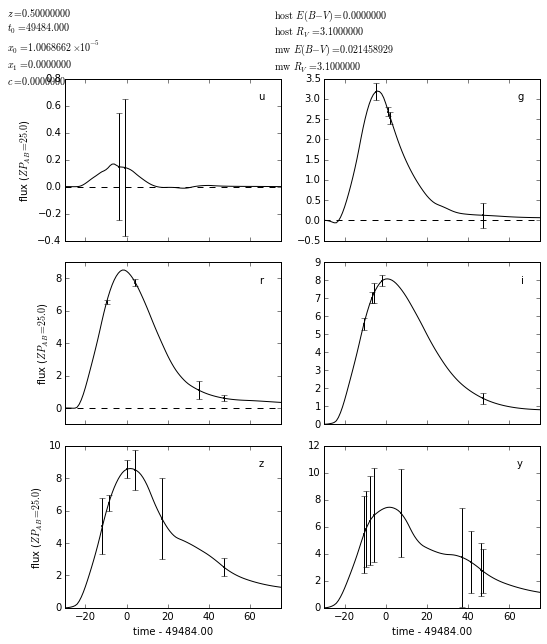

In [95]:
qm_0 = PerSNMetric(t0=49484, summarydf=_obsForSN(summarydf, 0), lsst_bp=lsst_bp, raCol='ditheredRA', decCol='ditheredDec')
fig = qm_0.lcplot(nightlyCoadd=True)
fig.savefig('results/SN_0.pdf')
qm_0.writeLightCurve('results/SN_0.dat', nightlyCoadd=True)

In [155]:
def writeResults(ind, mjd=49484):
    
    print '------------------------'
    print('Entering iteration ', ind)
    df = _obsForSN(summarydf, ind)
    print('Number of obs found ', len(df))
    tmp = PerSNMetric(t0=mjd, summarydf=df, 
                      lsst_bp=lsst_bp, raCol='ditheredRA', decCol='ditheredDec')
    fig = tmp.lcplot(nightlyCoadd=True)
    fig.savefig('results/SN_' + str(ind) + '_lc.pdf')
    tmp.writeLightCurve('results/SN_' +str(ind) + '.dat', nightlyCoadd=True)
    x = qm.showFields()
    x.savefig('results/SN_' +str(ind) + '_map.pdf')
    xx = tmp.cadence_plot(summarydf=df, racol='ditheredRA', deccol='ditheredDec', mjd_center=mjd)
    xx[0].savefig('results/SN_' + str(ind) + '_obs.pdf')
    print i, np.unique(tmp.fieldIds)
    print '---------------------------'

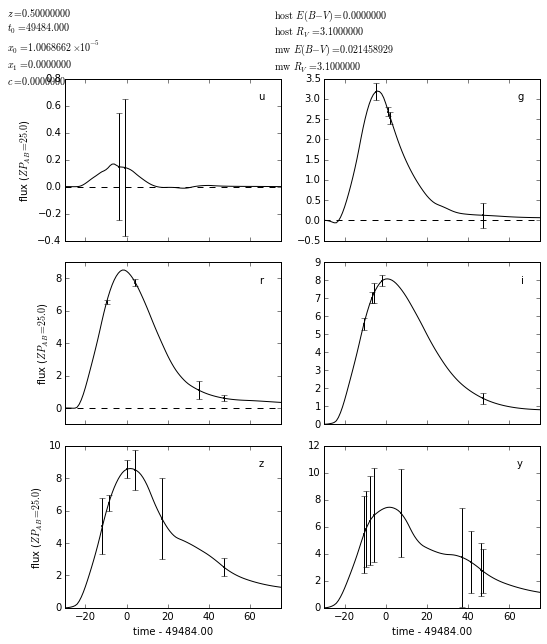

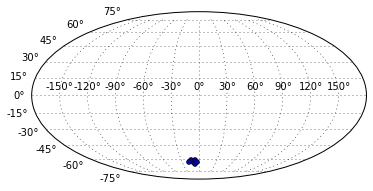

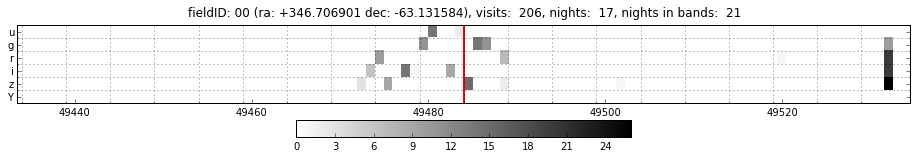

In [110]:
writeResults(0)

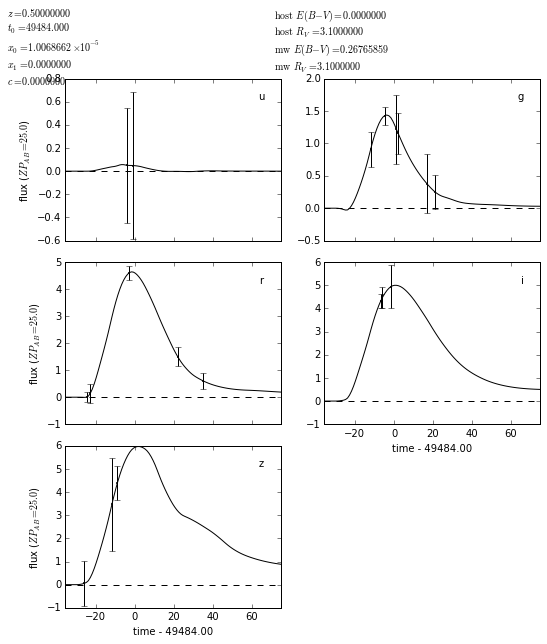

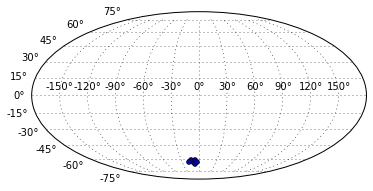

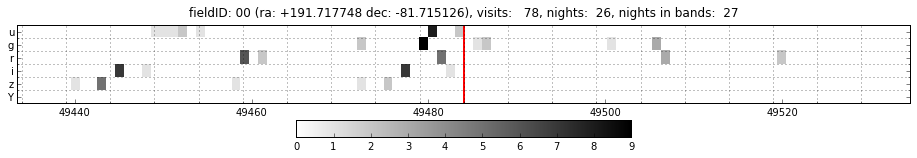

In [111]:
writeResults(1)

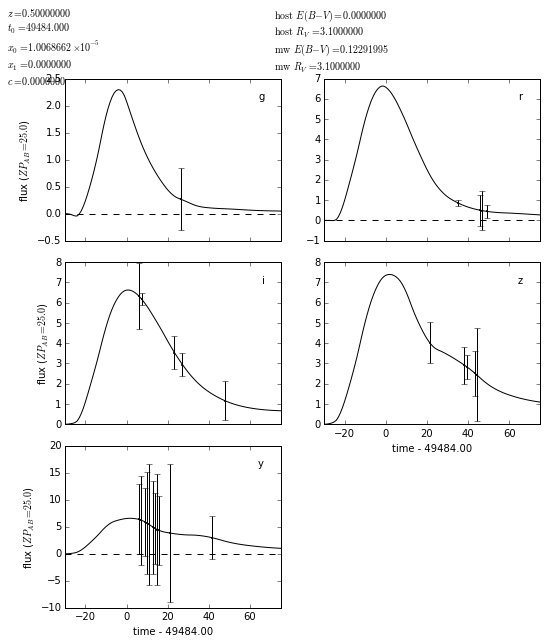

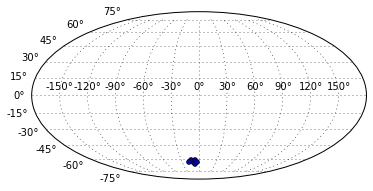

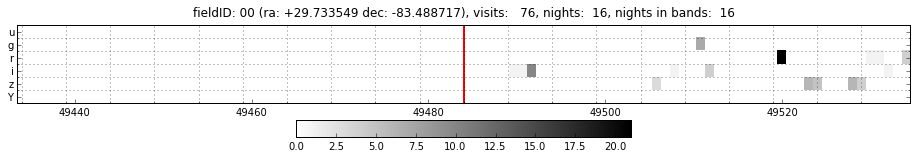

In [112]:
writeResults(2)

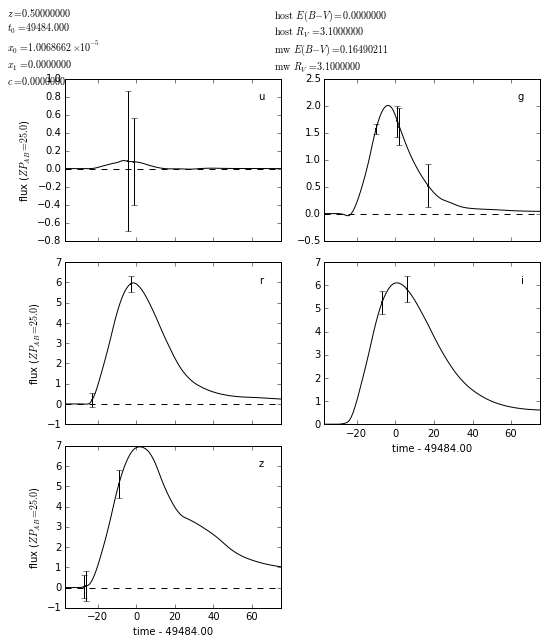

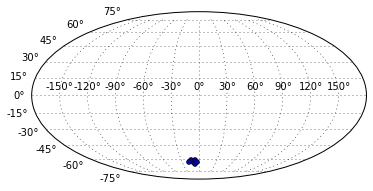

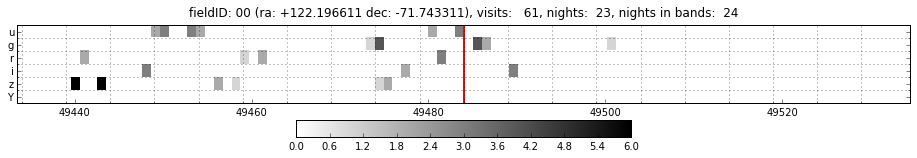

In [113]:
writeResults(3)

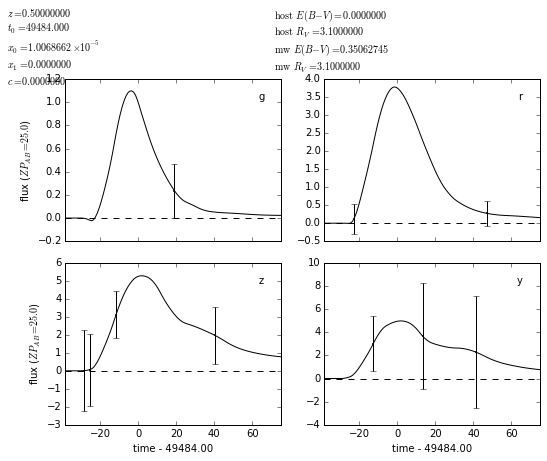

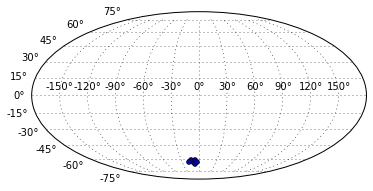

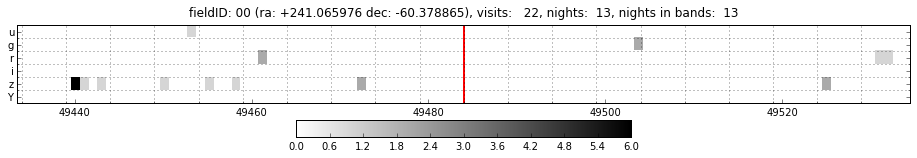

In [114]:
writeResults(4)

/usr/local/manual/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

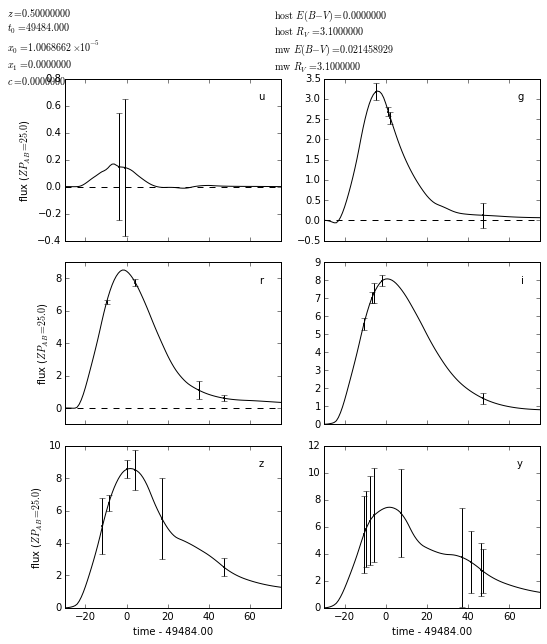

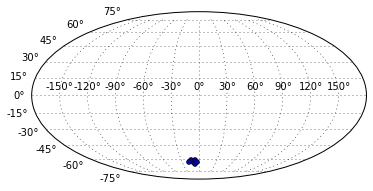

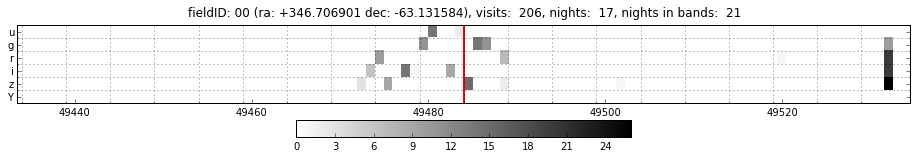

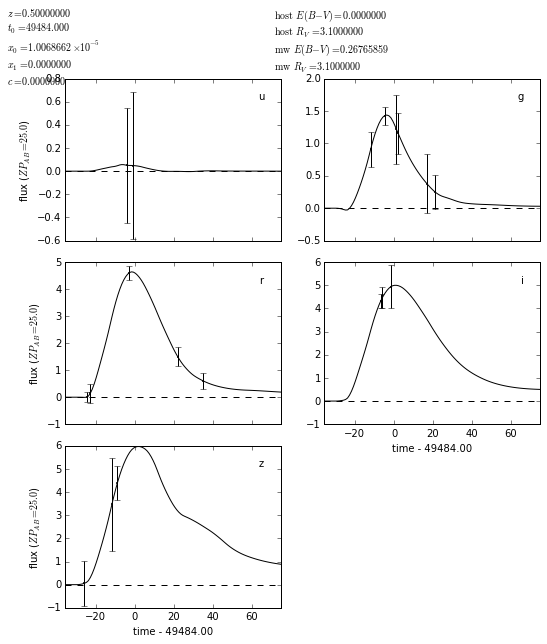

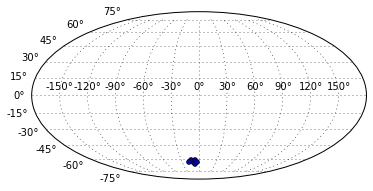

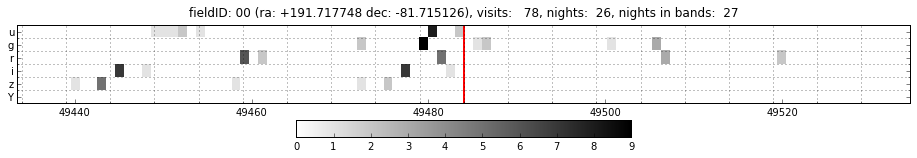

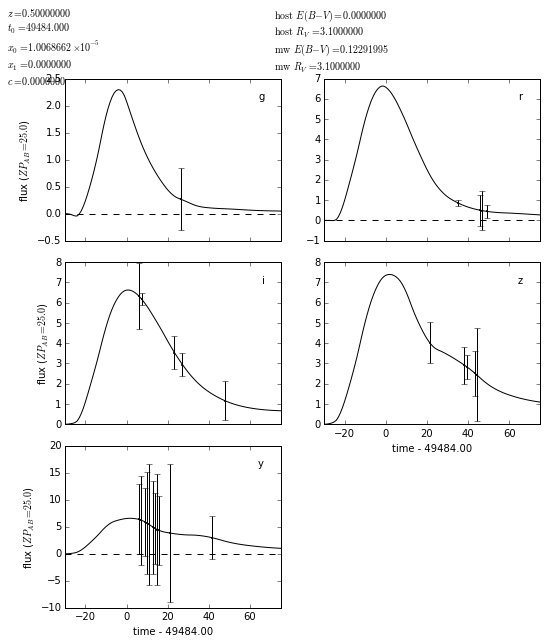

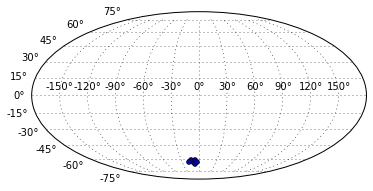

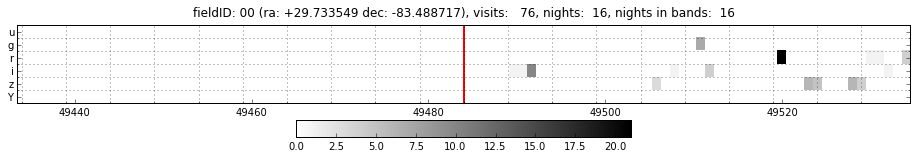

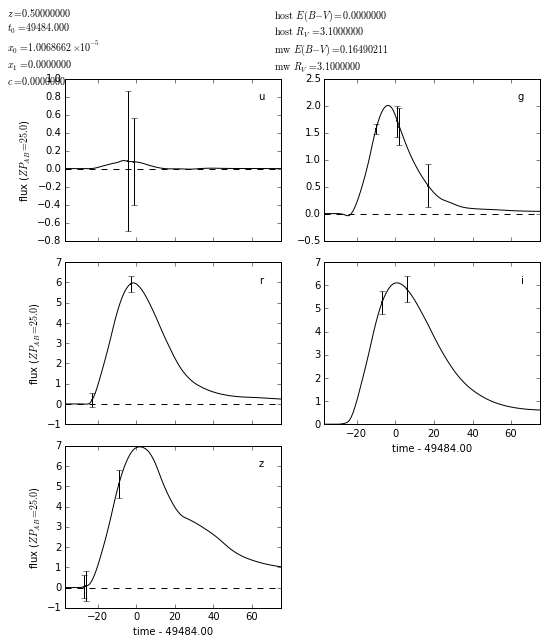

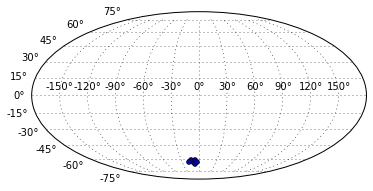

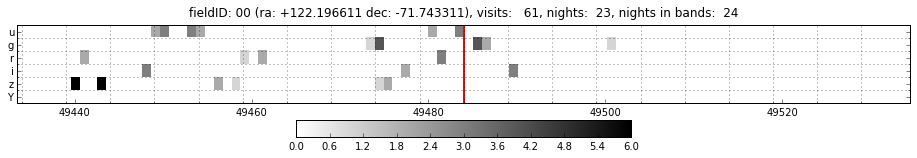

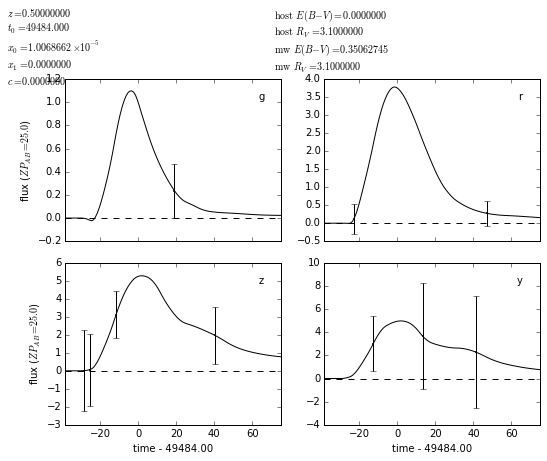

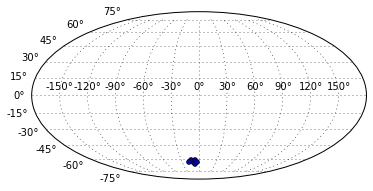

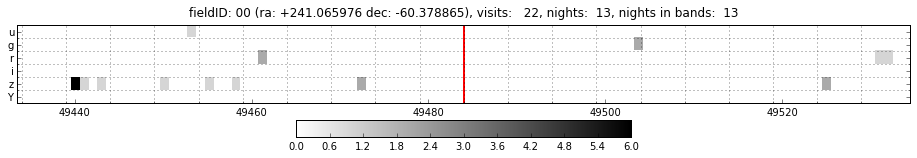

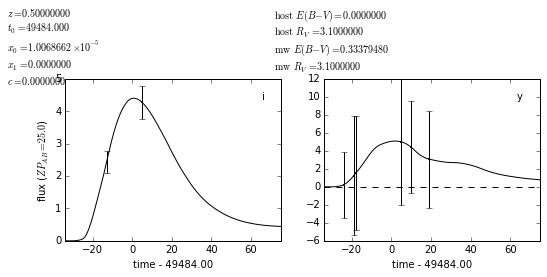

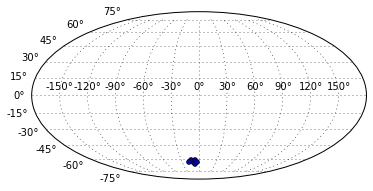

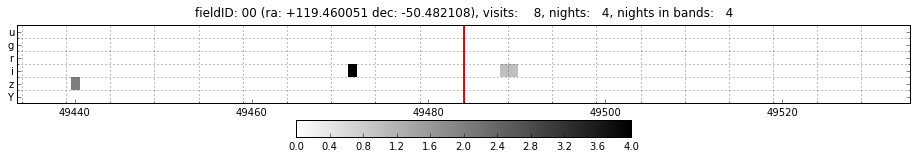

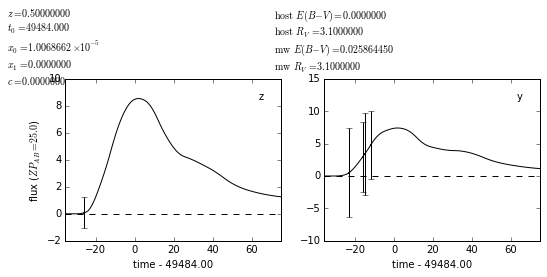

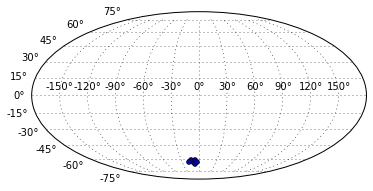

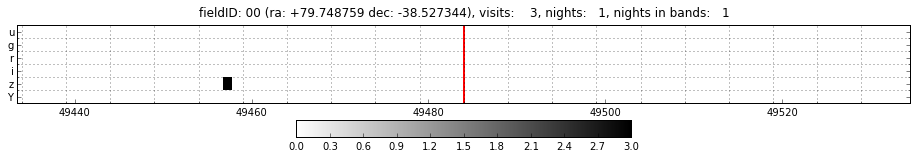

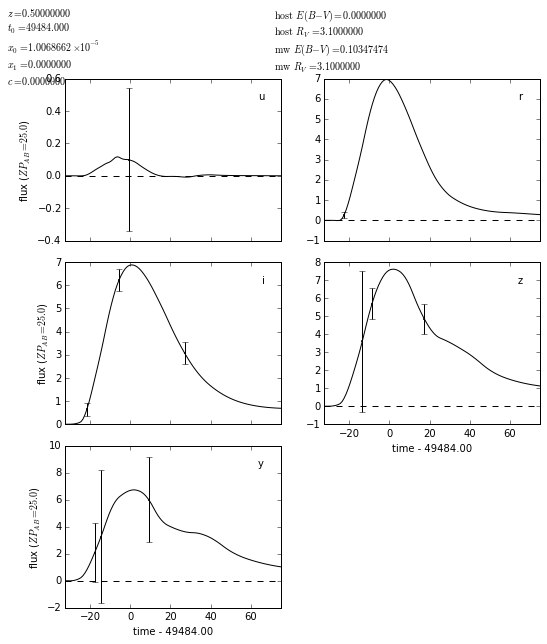

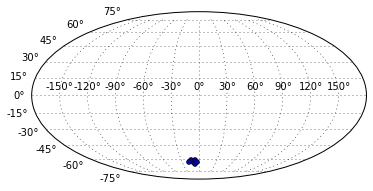

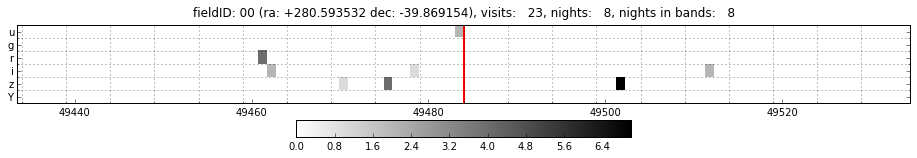

In [115]:
for i in range(len(posns)):
    writeResults(i)

In [116]:
len(posns)

17

------------------------
('Entering iteration ', 8)
('Number of obs found ', 1120)
8 [1623 1722 1754 1843]
---------------------------


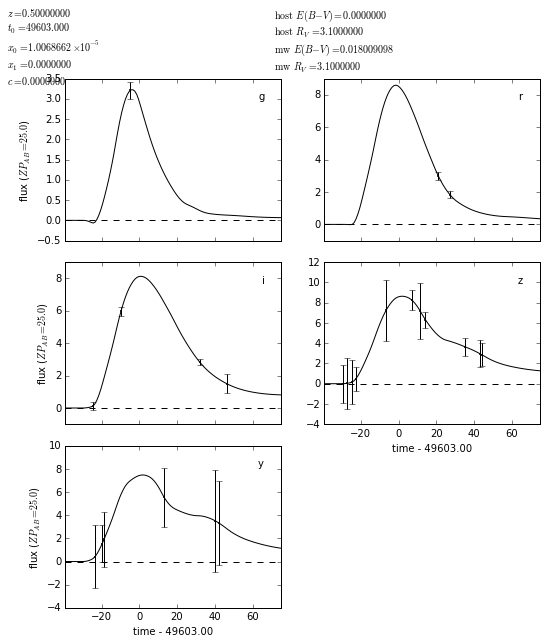

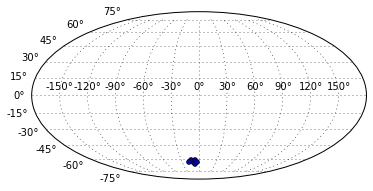

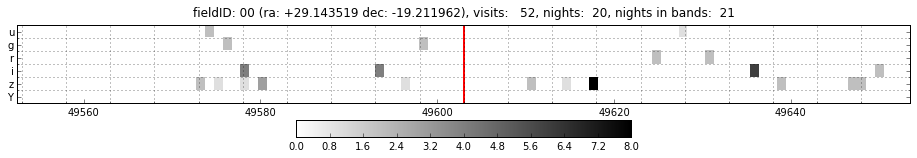

In [156]:
writeResults(8, mjd=49603)

In [170]:
writeResults(12, mjd=49603)

------------------------
('Entering iteration ', 12)
('Number of obs found ', 55)


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [121]:
ss = _obsForSN(summarydf, 8)

In [141]:

tmp = PerSNMetric(t0=49480, summarydf=ss, 
                      lsst_bp=lsst_bp, raCol='ditheredRA', decCol='ditheredDec')
    

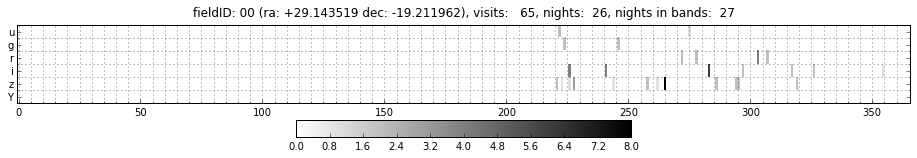

In [142]:
xx = tmp.cadence_plot(summarydf=ss, racol='ditheredRA', deccol='ditheredDec')

In [130]:
so = oss.SummaryOpsim(summarydf)

In [132]:
so.mjdvalfornight(250)

49603

8

AttributeError: 'NoneType' object has no attribute 'unique'

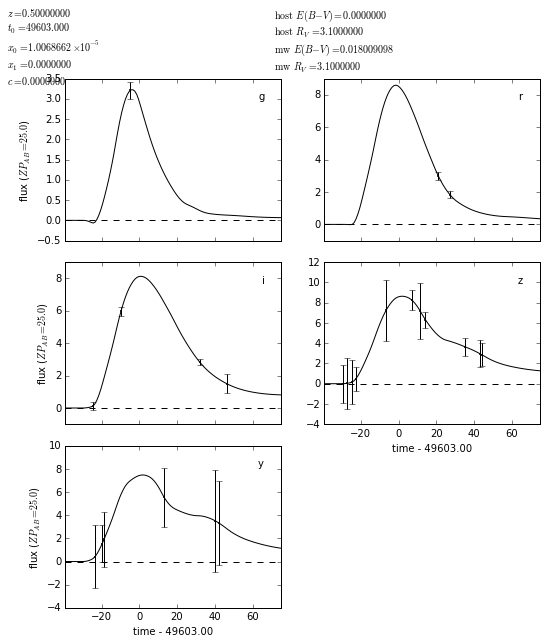

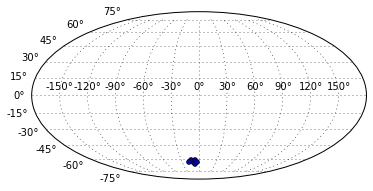

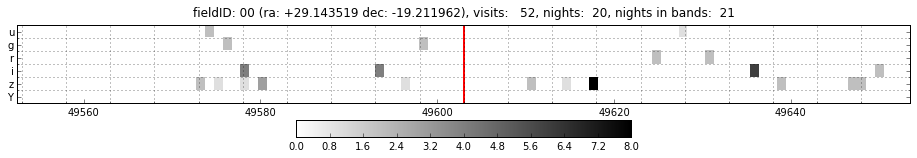

In [138]:
for ind in range(8, len(posns)):
    writeResults(ind, mjd=49603)

In [144]:
so.fi

------------------------
('Entering iteration ', 9)
('Number of obs found ', 1157)
8

AttributeError: 'list' object has no attribute 'unique'

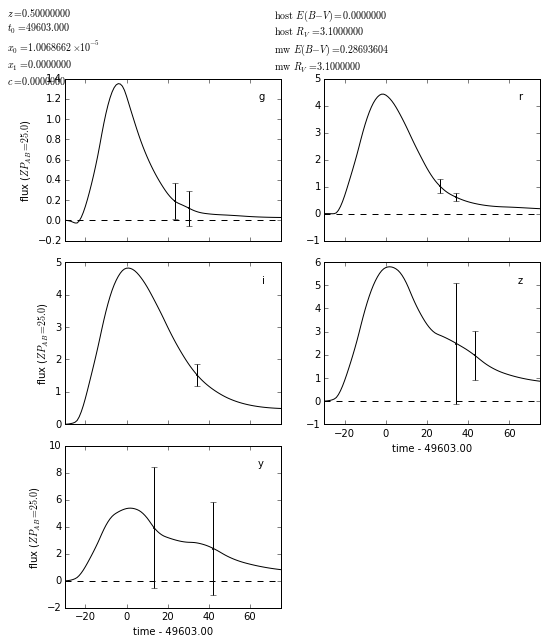

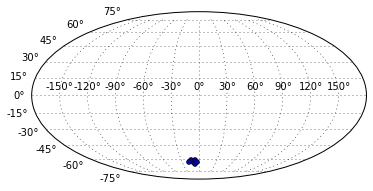

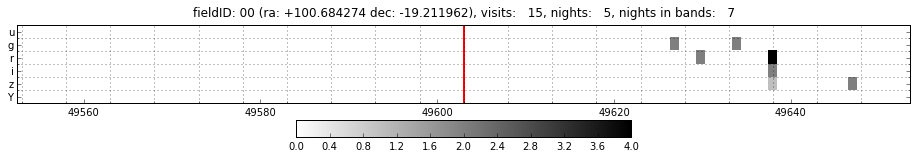

In [154]:
writeResults(9, 49603)

ValueError: cannot label index with a null key

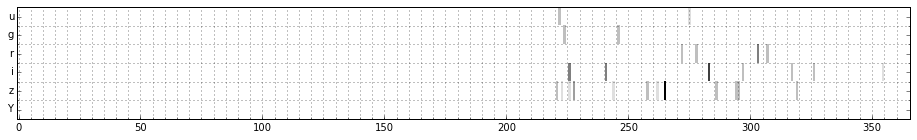

In [129]:
so.cadence_plot(summarydf=ss)

In [171]:
posns.to_csv('results/PosnList.csv', index=True)